# Subject-driven image generation and editing using BLIP Diffusion and OpenVINO
Blip Diffusion is a text-to-image diffusion model introduced in the paper ["BLIP-Diffusion: Pre-trained Subject Representation for Controllable Text-to-Image Generation and Editing" by Li et al. (2023)](https://arxiv.org/abs/2305.14720). It is a unique diffusion model, pre-trained on a multimodal dataset of text and images, enabling it to generate images that align more coherently with the subject of the text prompt.

Blip Diffusion undergoes a two-stage training process. In the initial stage, a multimodal encoder is pre-trained to acquire a representation of the text and images within the dataset. This encoder is specifically trained to capture informative features encompassing both the visual content of the images and the semantic content of the text.

In the second stage, the pre-trained multimodal encoder is employed to train a diffusion model. This diffusion model learns to generate images that closely correspond to the multimodal representation derived from the text prompt.

Once the diffusion model completes its training, it becomes capable of generating images from text prompts. The image generation process commences with a random noise image, progressively integrating more details until it faithfully mirrors the multimodal representation inherent in the text prompt.

Blip Diffusion offers several advantages over other text-to-image diffusion models. First, it excels at generating images that harmonize with the subject matter of the text prompt, owing to its pre-training on a multimodal dataset of text and images, which facilitates the understanding of the relationship between textual and visual elements.

Second, Blip Diffusion demonstrates a remarkable ability to produce diverse images. Unlike models reliant on fixed image templates, Blip Diffusion crafts images from scratch by leveraging the multimodal representation derived from the text prompt, fostering uniqueness in its outputs.

Third, Blip Diffusion excels at generating realistic images due to its training on a dataset containing real-world images.

In summary, Blip Diffusion stands as a potent text-to-image diffusion model for generating high-quality images from text prompts. It distinguishes itself through its capacity to produce images that align closely with the text prompt's subject, its versatility in generating diverse visuals from scratch, and its ability to craft realistic images In this tutorial we will show how to convert Blip Diffusion model to OpenVINO Intermediate Representation and perform inference.

## Prerequisites

In [1]:
%pip install -q "openvino==2023.1.0" torch transformers accelerate matplotlib Pillow numpy gradio controlnet_aux
%pip install -q "git+https://github.com/huggingface/diffusers.git" # TODO: Change to PyPI package where https://github.com/huggingface/diffusers/pull/4388 is included

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from pathlib import Path
import gc
from typing import List, Optional, Union
from functools import partial
from urllib.request import urlretrieve

import diffusers
import torch
import matplotlib.pyplot as plt
import ipywidgets
import PIL
import numpy as np
import transformers
import gradio as gr
import controlnet_aux

import openvino as ov

/home/itrushkin/.virtualenvs/blip_diffusion/lib/python3.10/site-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(


In [3]:
MODELS_DIR = Path("models")
QFORMER_PATH = MODELS_DIR / "qformer.xml"
TEXT_ENCODER_PATH = MODELS_DIR / "text_encoder.xml"
NEG_TEXT_ENCODER_PATH = MODELS_DIR / "neg_text_encoder.xml"
CONTROLNET_PATH = MODELS_DIR / "controlnet.xml"
UNET_PATH = MODELS_DIR / "unet.xml"
UNET_CONTROLNET_PATH = MODELS_DIR / "unet_controlnet.xml"
VAE_PATH = MODELS_DIR / "vae.xml"

DATA_DIR = Path("data")
DOG_IMG_URL = "https://huggingface.co/datasets/ayushtues/blipdiffusion_images/resolve/main/dog.jpg"
DOG_IMG_PATH = DATA_DIR / "dog.jpg"
KETTLE_IMG_URL = "https://huggingface.co/datasets/ayushtues/blipdiffusion_images/resolve/main/kettle.jpg"
KETTLE_IMG_PATH = DATA_DIR / "kettle.jpg"
FLOWER_IMG_URL = "https://huggingface.co/datasets/ayushtues/blipdiffusion_images/resolve/main/flower.jpg"
FLOWER_IMG_PATH = DATA_DIR / "flower.jpg"

MODELS_DIR.mkdir(parents=True, exist_ok=True)
DATA_DIR.mkdir(parents=True, exist_ok=True)

## Load the model

We use Hugging Face `diffusers` library to load the model using `from_pretrained` method.

In [4]:
pipe = diffusers.pipelines.BlipDiffusionPipeline.from_pretrained('ayushtues/blipdiffusion')
pipe_controlnet = diffusers.pipelines.BlipDiffusionControlNetPipeline.from_pretrained('ayushtues/blipdiffusion-controlnet')

text_encoder/model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

text_encoder/model.safetensors not found


Loading pipeline components...:   0%|          | 0/8 [00:00<?, ?it/s]

In [4]:
# Download images
urlretrieve(DOG_IMG_URL, DOG_IMG_PATH);
urlretrieve(KETTLE_IMG_URL, KETTLE_IMG_PATH);
urlretrieve(FLOWER_IMG_URL, FLOWER_IMG_PATH);

## Infer original model

### Zero-Shot subject-driven generation

In [6]:
dog_img = PIL.Image.open(DOG_IMG_PATH)
cond_subject = ["dog"]
tgt_subject = ["dog"]
text_prompt_input = ["swimming underwater"]
iter_seed = 88888
guidance_scale = 7.5
num_inference_steps = 50
negative_prompt = "over-exposure, under-exposure, saturated, duplicate, out of frame, lowres, cropped, worst quality, low quality, jpeg artifacts, morbid, mutilated, out of frame, ugly, bad anatomy, bad proportions, deformed, blurry, duplicate"

In [7]:
output = pipe(
        text_prompt_input,
        dog_img,
        cond_subject,
        tgt_subject,
        guidance_scale=guidance_scale,
        num_inference_steps=num_inference_steps,
        neg_prompt=negative_prompt,
        height=512,
        width=512,
    )

  0%|          | 0/51 [00:00<?, ?it/s]

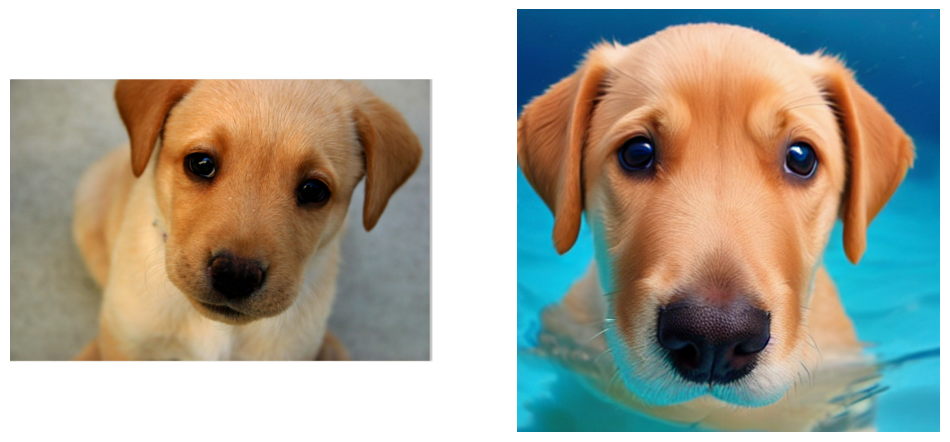

In [8]:
plt.figure(figsize=(12,12))
for i, x in enumerate([img, output["images"][0]]):
    plt.subplot(1,2,i+1)
    plt.imshow(x)
    plt.axis("off")

### Controlled subject-driven generation (Canny-edge)

In [9]:
style_subject = ["flower"] # subject that defines the style
tgt_subject = ["teapot"]  # subject to generate.
text_prompt = ["on a marble table"]
cond_image = PIL.Image.open(KETTLE_IMG_PATH).resize((512, 512))
canny = controlnet_aux.CannyDetector()
cldm_cond_image = canny(cond_image, 30, 70, output_type='pil')
cldm_cond_image = [cldm_cond_image ]

style_image = PIL.Image.open(FLOWER_IMG_PATH)


guidance_scale = 7.5
num_inference_steps = 50
negative_prompt = "over-exposure, under-exposure, saturated, duplicate, out of frame, lowres, cropped, worst quality, low quality, jpeg artifacts, morbid, mutilated, out of frame, ugly, bad anatomy, bad proportions, deformed, blurry, duplicate"

output = pipe_controlnet(
        text_prompt,
        style_image,
        cldm_cond_image,
        style_subject,
        tgt_subject,
        guidance_scale=guidance_scale,
        num_inference_steps=num_inference_steps,
        neg_prompt=negative_prompt,
        height=512,
        width=512,
    )

  0%|          | 0/51 [00:00<?, ?it/s]

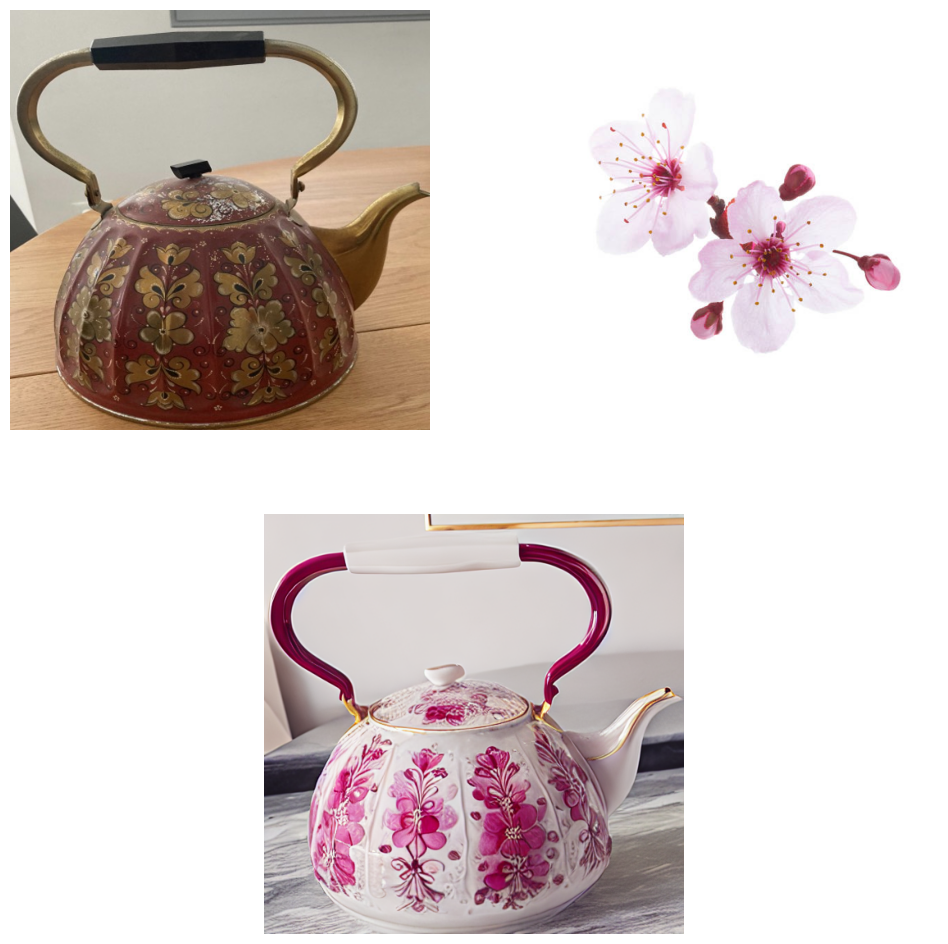

In [10]:
plt.figure(figsize=(12,12))
plt.subplot(2, 2, 1)
plt.imshow(cond_image)
plt.axis("off")
plt.subplot(2, 2, 2)
plt.imshow(style_image)
plt.axis("off")
plt.subplot(2,1,2)
plt.imshow(output[0][0])
plt.axis("off");

## Convert model to OpenVINO Intermediate Representation (IR)

In [11]:
# Extract all models from pipeline
qformer = pipe.qformer
qformer.eval()
text_encoder = pipe.text_encoder
text_encoder.eval()
unet = pipe.unet
unet.eval()
vae = pipe.vae
vae.eval()
controlnet = pipe_controlnet.controlnet
controlnet.eval()

# Extract additional instances
tokenizer = pipe.tokenizer
scheduler = pipe.scheduler
image_processor = pipe.image_processor
config = {
    "mean":pipe.config.mean,
    "std":pipe.config.std,
    "text_encoder_max_position_embeddings": pipe.text_encoder.text_model.config.max_position_embeddings,
    "qformer_num_query_tokens": pipe.qformer.config.num_query_tokens,
    "ctx_begin_pos": pipe.config.ctx_begin_pos,
    "unet_block_out_channels": pipe.unet.config.block_out_channels,
    "unet_in_channels": pipe.unet.config.in_channels,
}
unet_sample_size = pipe.unet.config.sample_size

del pipe
del pipe_controlnet
gc.collect()

4216

In [12]:
def serialize_openvino(model: torch.nn.Module, xml_path: Path, **convert_kwargs):
    if not xml_path.exists():
        converted_model = ov.convert_model(model, **convert_kwargs)
        ov.save_model(converted_model, xml_path)
        del converted_model
        
        # Clear torch.jit cache
        torch._C._jit_clear_class_registry()
        torch.jit._recursive.concrete_type_store = torch.jit._recursive.ConcreteTypeStore()
        torch.jit._state._clear_class_state()

        gc.collect()

### QFormer

Original QFormer model takes raw text as input, so we redefine the `forward` function to accept tokenization result as `input_ids` and `attention_mask` tensors.

In [13]:
class OVQFormer(torch.nn.Module):
    def __init__(self, qformer):
        super().__init__()
        self._qformer = qformer

    def __getattr__(self, name):
        if name == "_qformer":
            return super().__getattr__(name)
        return getattr(self._qformer, name)

    
    def forward(
        self,
        text_input_ids,
        text_attention_mask,
        image_input,
    ):

        batch_size = text_input_ids.shape[0]
        query_atts = torch.ones((batch_size, self.query_tokens.size()[1]), dtype=torch.long)
        attention_mask = torch.cat([query_atts, text_attention_mask], dim=1)

        output_attentions = self.config.output_attentions
        output_hidden_states = self.config.output_hidden_states
        return_dict = self.config.use_return_dict

        query_length = self.query_tokens.shape[1]

        embedding_output = self.embeddings(
            input_ids=text_input_ids,
            query_embeds=self.query_tokens
        )

        # embedding_output = self.layernorm(query_embeds)
        # embedding_output = self.dropout(embedding_output)

        input_shape = embedding_output.size()[:-1]
        batch_size, seq_length = input_shape
        device = embedding_output.device

        image_embeds_frozen = self.visual_encoder(image_input).last_hidden_state
        # image_embeds_frozen = torch.ones_like(image_embeds_frozen)
        encoder_hidden_states = image_embeds_frozen

        if attention_mask is None:
            attention_mask = torch.ones(((batch_size, seq_length)), device=device)

        # We can provide a self-attention mask of dimensions [batch_size, from_seq_length, to_seq_length]
        # ourselves in which case we just need to make it broadcastable to all heads.
        extended_attention_mask = self.get_extended_attention_mask(attention_mask, input_shape, device)

        # If a 2D or 3D attention mask is provided for the cross-attention
        # we need to make broadcastable to [batch_size, num_heads, seq_length, seq_length]
        if encoder_hidden_states is not None:
            if isinstance(encoder_hidden_states, list):
                encoder_batch_size, encoder_sequence_length, _ = encoder_hidden_states[0].size()
            else:
                encoder_batch_size, encoder_sequence_length, _ = encoder_hidden_states.size()
            encoder_hidden_shape = (encoder_batch_size, encoder_sequence_length)
            encoder_attention_mask = torch.ones(encoder_hidden_shape, device=device)
            encoder_extended_attention_mask = self.invert_attention_mask(encoder_attention_mask)
        else:
            encoder_extended_attention_mask = None

        head_mask = [None] * self.config.qformer_config.num_hidden_layers

        encoder_outputs = self.encoder(
            embedding_output,
            attention_mask=extended_attention_mask,
            head_mask=head_mask,
            encoder_hidden_states=encoder_hidden_states,
            encoder_attention_mask=encoder_extended_attention_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
            query_length=query_length,
        )
        sequence_output = encoder_outputs[0]
        pooled_output = sequence_output[:, 0, :]
        return self.proj_layer(sequence_output[:, :query_length, :])

In [14]:
serialize_openvino(
    OVQFormer(qformer),
    QFORMER_PATH,
    example_input={
        "image_input": torch.randn(1, 3, 16, 16),
        "text_input_ids": torch.zeros((1, 3), dtype=torch.int64),
        "text_attention_mask": torch.zeros((1, 3), dtype=torch.int64),
    },
    input={
        "image_input": ((1, 3, 224, 224),),
        "text_input_ids": ((1, 3), np.int64),
        "text_attention_mask": ((1, 3), np.int64),
    },
)

del qformer
gc.collect()

0

### Text encoder

In [16]:
serialize_openvino(
    text_encoder,
    TEXT_ENCODER_PATH,
    example_input={
        "input_ids": torch.zeros((1, 61), dtype=torch.int64),
        "ctx_embeddings": torch.zeros((1, 16, 768)),
        "ctx_begin_pos": torch.tensor([2]),
    },
    input={
        "input_ids": ((1, 61), np.int64),
        "ctx_embeddings": ((1, 16, 768),),
        "ctx_begin_pos": ((1),),
    },
)

# Convert 2nd instance for negative prompt encoding
serialize_openvino(
    text_encoder,
    NEG_TEXT_ENCODER_PATH,
    example_input={
        "input_ids": torch.zeros((1, 77), dtype=torch.int64),
    },
    input={
        "input_ids": ((1, 77), np.int64),
    },
)

del text_encoder
gc.collect()

0

### ControlNet

In [17]:
controlnet.forward = partial(controlnet.forward, return_dict=False)
example_input = {
        "sample": torch.randn(2, 4, 64, 64),
        "timestep": torch.tensor(1),
        "encoder_hidden_states": torch.randn(2, 77, 768),
        "controlnet_cond": torch.randn(2, 3, 512, 512),
    }
with torch.no_grad():
    down_block_res_samples, mid_block_res_sample = controlnet(**example_input)
serialize_openvino(
    controlnet,
    CONTROLNET_PATH,
    example_input=example_input,
    input={
        "sample": ((2, 4, 64, 64)),
        "timestep": ((),),
        "encoder_hidden_states": ((2, 77, 768),),
        "controlnet_cond": ((2, 3, 512, 512))
    },
)
del controlnet
gc.collect()

4463

### UNet

In [18]:
serialize_openvino(
    unet,
    UNET_PATH,
    example_input={
        "sample": torch.randn(2, 4, 32, 32),
        "timestep": torch.tensor(1),
        "encoder_hidden_states": torch.randn(2, 77, 768),
    },
    input={
        "sample": ((2, 4, unet_sample_size, unet_sample_size),),
        "timestep": ((),),
        "encoder_hidden_states": ((2, 77, 768),),
    },
)

dtype_mapping = {
    torch.float32: ov.Type.f32,
    torch.float64: ov.Type.f64,
    torch.int32: ov.Type.i32,
    torch.int64: ov.Type.i64
}

def flatten_inputs(inputs):
    flat_inputs = []
    for input_data in inputs:
        if input_data is None:
            continue
        if isinstance(input_data, (list, tuple)):
            flat_inputs.extend(flatten_inputs(input_data))
        else:
            flat_inputs.append(input_data)
    return flat_inputs

# convert 2nd time for stylization task
example_input={
                "sample": torch.randn(2, 4, unet_sample_size, unet_sample_size),
                "timestep": torch.tensor(1),
                "encoder_hidden_states": torch.randn(2, 77, 768),
                "down_block_additional_residuals": down_block_res_samples,
                "mid_block_additional_residual": mid_block_res_sample
            }
if not UNET_CONTROLNET_PATH.exists():
    with torch.no_grad():
        ov_unet = ov.convert_model(
            unet,
            example_input=example_input,
        )
    flat_inputs = flatten_inputs(example_input.values())
    for input_data, input_tensor in zip(flat_inputs, ov_unet.inputs):
        input_tensor.get_node().set_partial_shape(ov.PartialShape(input_data.shape))
        input_tensor.get_node().set_element_type(dtype_mapping[input_data.dtype])
    ov_unet.validate_nodes_and_infer_types()
    ov.save_model(ov_unet, UNET_CONTROLNET_PATH)
    del ov_unet
del unet
gc.collect()

0

### Variational Autoencoder (VAE)

For inference we use only decoding part of the VAE. We wrap the decoder in separate `torch.nn.Module`.

In [19]:
class VaeDecoderWrapper(torch.nn.Module):
    def __init__(self, vae: torch.nn.Module):
        super().__init__()
        self.vae = vae

    def forward(self, z: torch.FloatTensor):
        return self.vae.decode(z / self.vae.config.scaling_factor, return_dict=False)[0]


serialize_openvino(
    VaeDecoderWrapper(vae),
    VAE_PATH,
    example_input=torch.randn(1, 4, 64, 64),
    input=((1, 4, 64, 64)),
)
del vae
gc.collect()


0

### Select inference device

select device from dropdown list for running inference using OpenVINO

In [20]:
core = ov.Core()

device = ipywidgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value="AUTO",
    description="Device:",
    disabled=False,
)
device

Dropdown(description='Device:', index=4, options=('CPU', 'GPU.0', 'GPU.1', 'GPU.2', 'AUTO'), value='AUTO')

In [21]:
qformer = core.compile_model(QFORMER_PATH, device_name=device.value)

In [22]:
text_encoder = core.compile_model(TEXT_ENCODER_PATH, device_name=device.value)

In [23]:
neg_text_encoder = core.compile_model(NEG_TEXT_ENCODER_PATH, device_name=device.value)

In [24]:
controlnet = core.compile_model(CONTROLNET_PATH, device_name=device.value)

In [25]:
unet = core.compile_model(UNET_PATH, device_name=device.value)

In [26]:
unet_controlnet = core.compile_model(UNET_CONTROLNET_PATH, device_name=device.value)

In [27]:
vae = core.compile_model(VAE_PATH, device_name=device.value)

## Inference

In [28]:
def call(compiled_model, *args, **kwargs):
    if len(args) and not kwargs:
        result = compiled_model([np.array(a) for a in args])[0]
    elif kwargs and not len(args):
        result = compiled_model({k: np.array(v) for k, v in kwargs.items()})[0]
    else:
        raise NotImplementedError(f"{args=},{kwargs=}")
    result = torch.tensor(result)
    return result

In [29]:
class OvBlipDiffusionPipeline(diffusers.DiffusionPipeline):
    def __init__(self):
        self.tokenizer = tokenizer
        self.qformer_tokenizer = transformers.BertTokenizer.from_pretrained(
            "bert-base-uncased", truncation_side="right"
        )
        self.text_encoder = partial(call, text_encoder)
        self.neg_text_encoder = partial(call, neg_text_encoder)
        self.vae = partial(call, vae)
        self.unet = partial(call, unet)
        self.unet_controlnet = partial(call, unet_controlnet)
        self.controlnet = controlnet
        self.scheduler = scheduler
        self.qformer = partial(call, qformer)
        self.image_processor = image_processor
        self.register_to_config(**config)

    def __call__(
        self,
        prompt: List[str],
        reference_image: PIL.Image.Image,
        source_subject_category: List[str],
        target_subject_category: List[str],
        conditioning_image: Optional[PIL.Image.Image] = None,
        latents: Optional[torch.FloatTensor] = None,
        guidance_scale: float = 7.5,
        num_inference_steps: int = 50,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        neg_prompt: Optional[str] = "",
        prompt_strength: float = 1.0,
        prompt_reps: int = 20,
        output_type: Optional[str] = "pil",
    ):
        """
        Function invoked when calling the pipeline for generation.

        Args:
            prompt (`List[str]`):
                The prompt or prompts to guide the image generation.
            reference_image (`PIL.Image.Image`):
                The reference image to condition the generation on.
            source_subject_category (`List[str]`):
                The source subject category.
            target_subject_category (`List[str]`):
                The target subject category.
            conditioning_image (`PIL.Image.Image`):
                The conditioning canny edge image to condition the generation on.
            latents (`torch.FloatTensor`, *optional*):
                Pre-generated noisy latents, sampled from a Gaussian distribution, to be used as inputs for image
                generation. Can be used to tweak the same generation with different prompts. If not provided, a latents
                tensor will ge generated by random sampling.
            guidance_scale (`float`, *optional*, defaults to 7.5):
                Guidance scale as defined in [Classifier-Free Diffusion Guidance](https://arxiv.org/abs/2207.12598).
                `guidance_scale` is defined as `w` of equation 2. of [Imagen
                Paper](https://arxiv.org/pdf/2205.11487.pdf). Guidance scale is enabled by setting `guidance_scale >
                1`. Higher guidance scale encourages to generate images that are closely linked to the text `prompt`,
                usually at the expense of lower image quality.
            num_inference_steps (`int`, *optional*, defaults to 50):
                The number of denoising steps. More denoising steps usually lead to a higher quality image at the
                expense of slower inference.
            generator (`torch.Generator` or `List[torch.Generator]`, *optional*):
                One or a list of [torch generator(s)](https://pytorch.org/docs/stable/generated/torch.Generator.html)
                to make generation deterministic.
            neg_prompt (`str`, *optional*, defaults to ""):
                The prompt or prompts not to guide the image generation. Ignored when not using guidance (i.e., ignored
                if `guidance_scale` is less than `1`).
            prompt_strength (`float`, *optional*, defaults to 1.0):
                The strength of the prompt. Specifies the number of times the prompt is repeated along with prompt_reps
                to amplify the prompt.
            prompt_reps (`int`, *optional*, defaults to 20):
                The number of times the prompt is repeated along with prompt_strength to amplify the prompt.
            output_type (`str`, *optional*, defaults to `"pil"`):
                The output format of the generate image. Choose between: `"pil"` (`PIL.Image.Image`), `"np"`
                (`np.array`) or `"pt"` (`torch.Tensor`).
        """
        width = 512
        height = 512
        reference_image = self.image_processor.preprocess(
            reference_image,
            image_mean=self.config.mean,
            image_std=self.config.std,
            return_tensors="pt",
        )["pixel_values"]

        if isinstance(prompt, str):
            prompt = [prompt]
        if isinstance(source_subject_category, str):
            source_subject_category = [source_subject_category]
        if isinstance(target_subject_category, str):
            target_subject_category = [target_subject_category]

        batch_size = len(prompt)

        prompt = self._build_prompt(
            prompts=prompt,
            tgt_subjects=target_subject_category,
            prompt_strength=prompt_strength,
            prompt_reps=prompt_reps,
        )
        qformer_input = self.qformer_tokenizer(
            source_subject_category, return_tensors="pt", padding=True
        )
        query_embeds = self.qformer(
            image_input=reference_image,
            text_input_ids=qformer_input.input_ids,
            text_attention_mask=qformer_input.attention_mask,
        )
        text_embeddings = self.encode_prompt(query_embeds, prompt, device)
        do_classifier_free_guidance = guidance_scale > 1.0
        if do_classifier_free_guidance:
            max_length = self.config.text_encoder_max_position_embeddings

            uncond_input = self.tokenizer(
                [neg_prompt] * batch_size,
                padding="max_length",
                max_length=max_length,
                return_tensors="pt",
            )
            uncond_embeddings = self.neg_text_encoder(input_ids=uncond_input.input_ids)
            # For classifier free guidance, we need to do two forward passes.
            # Here we concatenate the unconditional and text embeddings into a single batch
            # to avoid doing two forward passes
            text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

        scale_down_factor = 2 ** (len(self.config.unet_block_out_channels) - 1)
        latents = self.prepare_latents(
            batch_size=batch_size,
            num_channels=self.config.unet_in_channels,
            height=height // scale_down_factor,
            width=width // scale_down_factor,
            generator=generator,
            latents=latents,
            device=None,
            dtype=None,
        )
        # set timesteps
        extra_set_kwargs = {}
        self.scheduler.set_timesteps(num_inference_steps, **extra_set_kwargs)

        if conditioning_image:
            cond_image = self.prepare_control_image(
                image=conditioning_image,
                width=width,
                height=height,
                batch_size=batch_size,
                num_images_per_prompt=1,
                device=None,
                dtype=None,
                do_classifier_free_guidance=do_classifier_free_guidance,
            )
        for i, t in enumerate(self.progress_bar(self.scheduler.timesteps)):
            # expand the latents if we are doing classifier free guidance
            do_classifier_free_guidance = guidance_scale > 1.0

            latent_model_input = (
                torch.cat([latents] * 2) if do_classifier_free_guidance else latents
            )
            if conditioning_image:
                controlnet_output = self.controlnet([
                    latent_model_input,
                    t,
                    text_embeddings,
                    cond_image,
                ])
            noise_pred = self.unet(
                sample=latent_model_input, timestep=t, encoder_hidden_states=text_embeddings
            ) if not conditioning_image else self.unet_controlnet(
                latent_model_input, t, text_embeddings, *[v for _, v in controlnet_output.items()]
            )

            # perform guidance
            if do_classifier_free_guidance:
                noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                noise_pred = noise_pred_uncond + guidance_scale * (
                    noise_pred_text - noise_pred_uncond
                )

            latents = self.scheduler.step(
                noise_pred,
                t,
                latents,
            )["prev_sample"]

        image = self.vae(latents)
        image = self.image_processor.postprocess(image, output_type=output_type)
        return image

    def encode_prompt(self, query_embeds, prompt, device=None):
        # embeddings for prompt, with query_embeds as context
        max_len = self.config.text_encoder_max_position_embeddings
        max_len -= self.config.qformer_num_query_tokens

        tokenized_prompt = self.tokenizer(
            prompt,
            padding="max_length",
            truncation=True,
            max_length=max_len,
            return_tensors="pt",
        )

        batch_size = query_embeds.shape[0]
        ctx_begin_pos = [self.config.ctx_begin_pos] * batch_size

        text_embeddings = self.text_encoder(
            input_ids=tokenized_prompt.input_ids,
            ctx_embeddings=query_embeds,
            ctx_begin_pos=ctx_begin_pos,
        )

        return text_embeddings

OvBlipDiffusionPipeline.prepare_control_image = diffusers.pipelines.BlipDiffusionControlNetPipeline.prepare_control_image
OvBlipDiffusionPipeline._build_prompt = diffusers.pipelines.BlipDiffusionPipeline._build_prompt
OvBlipDiffusionPipeline.prepare_latents = diffusers.pipelines.BlipDiffusionPipeline.prepare_latents

In [30]:
ov_pipe = OvBlipDiffusionPipeline()

### Zero-Shot subject-driven generation

  0%|          | 0/51 [00:00<?, ?it/s]

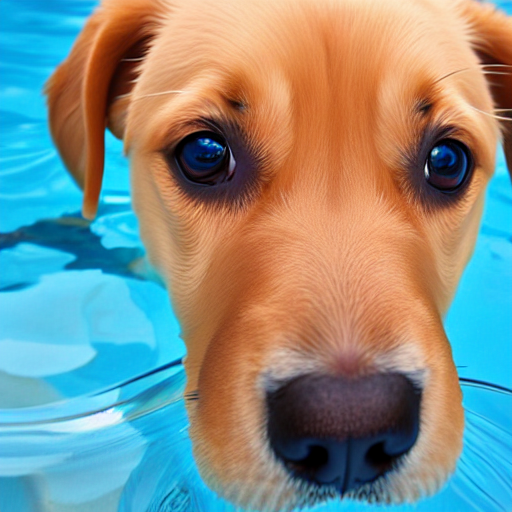

In [31]:
result = ov_pipe(
        text_prompt_input,
        dog_img,
        cond_subject,
        tgt_subject,
        guidance_scale=guidance_scale,
        num_inference_steps=num_inference_steps,
        neg_prompt=negative_prompt
    )
result[0]

### Controlled subject-driven generation (Canny-edge)

In [32]:
style_subject = ["flower"] # subject that defines the style
tgt_subject = ["teapot"]  # subject to generate.
text_prompt = ["on a marble table"]
cond_image = PIL.Image.open(KETTLE_IMG_PATH).resize((512, 512))
canny = controlnet_aux.CannyDetector()
cldm_cond_image = canny(cond_image, 30, 70, output_type='pil')
cldm_cond_image = [cldm_cond_image ]

style_image = PIL.Image.open(FLOWER_IMG_PATH)


guidance_scale = 7.5
num_inference_steps = 50
negative_prompt = "over-exposure, under-exposure, saturated, duplicate, out of frame, lowres, cropped, worst quality, low quality, jpeg artifacts, morbid, mutilated, out of frame, ugly, bad anatomy, bad proportions, deformed, blurry, duplicate"

output = ov_pipe(
        text_prompt,
        style_image,
        style_subject,
        tgt_subject,
        cldm_cond_image,
        guidance_scale=guidance_scale,
        num_inference_steps=num_inference_steps,
        neg_prompt=negative_prompt,
        height=512,
        width=512,
    )

  0%|          | 0/51 [00:00<?, ?steps/s]

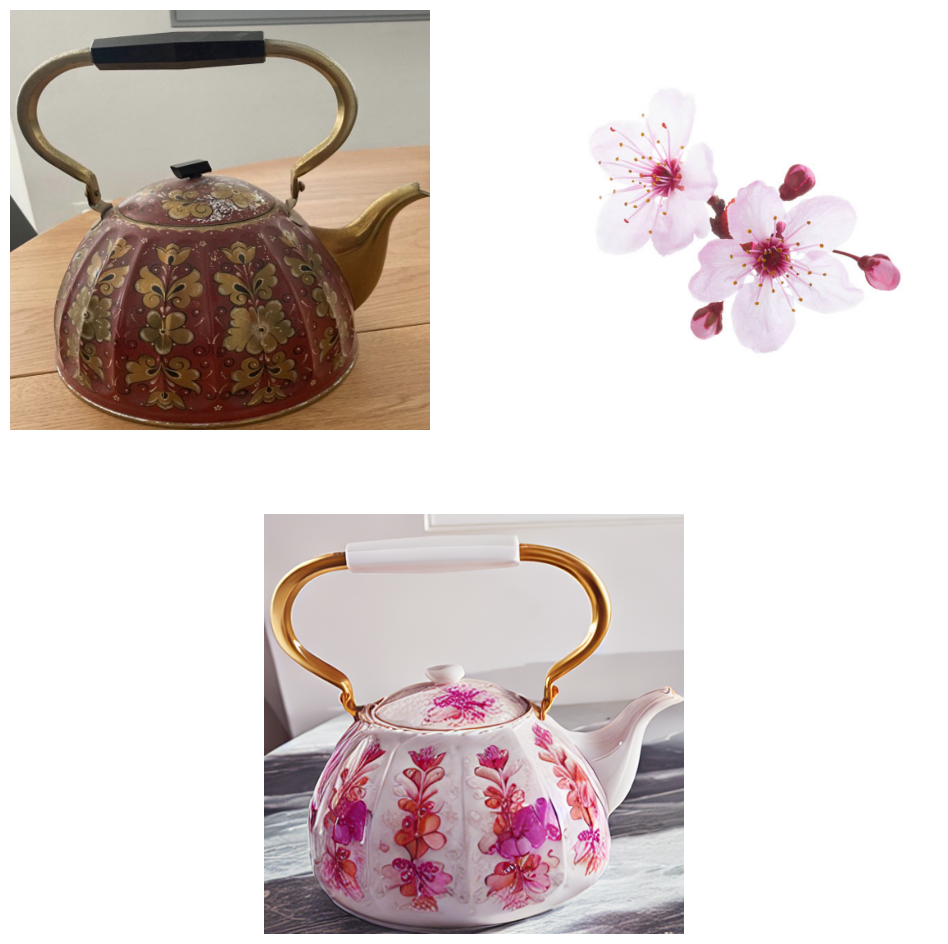

In [33]:
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plt.imshow(cond_image)
plt.axis("off")
plt.subplot(2,2,2)
plt.imshow(style_image)
plt.axis("off")
plt.subplot(2,1,2)
plt.imshow(output[0])
plt.axis("off");

## Interactive inference

In [34]:
def generate(
    prompt,
    reference_img,
    src_subject_category,
    tgt_subject_category,
    guidance_scale,
    num_inference_steps,
    seed,
    neg_prompt,
    _=gr.Progress(track_tqdm=True)
):
    generator = torch.Generator().manual_seed(seed)
    output = ov_pipe(
        prompt=prompt,
        reference_image=reference_img,
        source_subject_category=src_subject_category,
        target_subject_category=tgt_subject_category,
        guidance_scale=guidance_scale,
        num_inference_steps=num_inference_steps,
        generator=generator,
        neg_prompt=neg_prompt
    )
    return output[0]

def generate_canny(
    prompt,
    reference_img,
    src_subject_category,
    tgt_subject_category,
    conditioning_image,
    guidance_scale,
    num_inference_steps,
    seed,
    neg_prompt,
    _=gr.Progress(track_tqdm=True)
):
    conditioning_image = conditioning_image.resize((512, 512))
    canny = controlnet_aux.CannyDetector()
    cldm_cond_image = canny(conditioning_image, 30, 70, output_type='pil')
    cldm_cond_image = [cldm_cond_image]
    generator = torch.Generator().manual_seed(seed)
    output = ov_pipe(
        prompt=prompt,
        reference_image=reference_img,
        source_subject_category=src_subject_category,
        target_subject_category=tgt_subject_category,
        conditioning_image=cldm_cond_image,
        guidance_scale=guidance_scale,
        num_inference_steps=num_inference_steps,
        generator=generator,
        neg_prompt=neg_prompt,
    )
    return output[0]

In [35]:
with gr.Blocks() as demo:
    with gr.Tab("Zero-shot subject-driven generation"):
        with gr.Row():
            with gr.Column():
                inputs = [
                    gr.Textbox(label="Prompt"),
                    gr.Image(label="Reference image", type="pil"),
                    gr.Textbox(label="Source subject category"),
                    gr.Textbox(label="Target subject category"),
                    gr.Slider(1.1, 10, value=7.5, label="Guidance scale"),
                    gr.Slider(1, 100, value=50, label="Number of inference steps"),
                    gr.Slider(0, 1_000_000, value=0, label="Random seed"),
                    gr.Textbox(label="Negative prompt"),
                ]
                btn = gr.Button()
            with gr.Column():
                output = gr.Image(type="pil")
        btn.click(generate, inputs, output)
        gr.Examples(
            [
                [
                    "swimming underwater",
                    DOG_IMG_PATH,
                    "dog",
                    "dog",
                    7.5,
                    50,
                    88888,
                    "over-exposure, under-exposure, saturated, duplicate, out of frame, lowres, cropped, worst quality, low quality, jpeg artifacts, morbid, mutilated, out of frame, ugly, bad anatomy, bad proportions, deformed, blurry, duplicate",
                ]
            ],
            inputs,
        )
    with gr.Tab("Controlled subject-driven generation (Canny-edge)"):
        with gr.Row():
            with gr.Column():
                inputs = [
                    gr.Textbox(label="Prompt"),
                    gr.Image(label="Reference image", type="pil"),
                    gr.Textbox(label="Source subject category"),
                    gr.Textbox(label="Target subject category"),
                    gr.Image(label="Conditioning image", type="pil"),
                    gr.Slider(1.1, 10, value=7.5, label="Guidance scale"),
                    gr.Slider(1, 100, value=50, label="Number of inference steps"),
                    gr.Slider(0, 1_000_000, value=0, label="Random seed"),
                    gr.Textbox(label="Negative prompt"),
                ]
                btn = gr.Button()
            with gr.Column():
                output = gr.Image(type="pil")
        btn.click(generate_canny, inputs, output)
        gr.Examples(
            [
                [
                    "on a marble table",
                    FLOWER_IMG_PATH,
                    "flower",
                    "teapot",
                    KETTLE_IMG_PATH,
                    7.5,
                    50,
                    88888,
                    "over-exposure, under-exposure, saturated, duplicate, out of frame, lowres, cropped, worst quality, low quality, jpeg artifacts, morbid, mutilated, out of frame, ugly, bad anatomy, bad proportions, deformed, blurry, duplicate",
                ]
            ],
            inputs,
        )
                
demo.queue().launch(share=True)